In [ ]:
import threading
from typing import Set
from bs4 import BeautifulSoup
import requests
import re
import PyPDF2, urllib
import io
from time import sleep
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
from dataclasses import dataclass, field
import csv
import datetime


class Parser(tk.Tk):
    # class representing a scientific event
    @dataclass
    class Event:
        url: str  # event url
        title: str  # the name of the event
        articles_count: int  # the number of articles that were written by teachers from the list
        references_count: int  # number of links to teachers within articles
        authors: Set  # a set of article authors
        references: Set  # the set of teachers to which references were found
        score: float = field(init=False)  # the final score of the event

        #  function to calculate the final score of the event
        def calculate_score(self):
            self.score = round(self.articles_count * Parser.article_weight +
                               self.references_count * Parser.reference_weight, 1)

        def __post_init__(self):
            self.calculate_score()  #calculate the final weight

        #  methods for sorting events
        def __gt__(self, other):
            return self.score > other.score

        def __lt__(self, other):
            return self.score < other.score

    #  Default weighting values that the user can edit
    article_weight = 1
    reference_weight = 0.1
    lower_limit = 1
    upper_limit = 0
    latest_event = 3139

    USER_AGENT = 'Mozilla/5.0'
    #  Faculty names
    professors = {'Vitaliy Snytyuk', 'Natalia Tmienova', 'Vitaliy Tsyganok', 'Hryhorii Hnatiienko', 'Nikolay Kiktev', 
                  'Oleg Ilarionov','Oksana Vlasenko', 'Georgy Gaina', 'Snizhana Gamotska', 'Iryna Domanetska', 'Olexander Kruglov',
                  'Ganna Krasovska', 'Volodymir Kudin', 'Julia Minaeva', 'Julia Nakvasiuk', 'Natalia Pashynska', 'Yuri Samokhvalov',
                 'Petro Soroka', 'Olena Fedusenko', 'Alexiy Bychkov', 'Denys Berestov', 'Maxim Brazhynenko', 'Anastasia Vecherkovska',
                 'Sergiy Dotsenko', 'Ksenia Dukhnovska', 'Elyzaveta Zhabska', 'Liudmila Zubyk', 'Anastasia Ivanytska', 'Evgen Ivanov',
                 'Tetiana Kovaliuk', 'Oksana Kovtun', 'Oleg Kurchenko', 'Anna Martsafei', 'Kateryna Merkulova', 'Anastasia Nikolaenko',
                 'Svetlana Popereshniak', 'Gennady Poriev', 'Maxim Tkachenko', 'Ruslan Fedorenko', 'Victor Shevchenko', 'Iryna Iurchuk',
                 'Natalia Lukova-Chuiko', 'Tetiana Babenko', 'Andriy Bigdan', 'Olena Boguslavska', 'Mykola Brailovskyi', 'Sergiy Buchyk',
                 'Sergiy Dakov', 'Olexander Laptiev', 'Larisa Myrutenko', 'Inna Mychalchuk', 'Volodymir Nakonechnyi', 'Ivan Parkhomenko',
                 'Sergiy Tolyupa', 'Olexander Toroshanko', 'Andriy Fesenko', 'Yanina Shestak', 'Yuri Shcheblanin', 'Victor Morozov', 'Alexiy Yehorchenkov',
                 'Bogdan Yeremenko', 'Anna Kolomiets', 'Liubov Kubiavka', 'Tetiana Latysheva', 'Daria Mochalova', 'Natalia Oberemok', 'Grygory Steshenko',
                 'Olexander Timinskyi', 'Julia Khlevna', 'Andriy Khlevnyi', 'Andriy Onyshchenko', 'Sergiy Bronin', 'Miroslava Hladka', 'Mykola Kostikov',
                 'Olga Kravchenko', 'Olexander Kuchanskyi', 'Rostislav Lisnevskyi', 'Sergiy Paliy', 'Roman Ponomarenko', 'Mykhailo Stepanov',
                 'Ivan Chychkan', 'Yuri Kravchenko', 'Oksana Herasymenko', 'Kostyantyn Herasymenko', 'Natalia Dakhno', 'Andriy Dudnik', 
                  'Olga Leshchenko', 'Olexander Makhovych', 'Roman Mykolaichuk', 'Olexander Pliushch', 'Olena Starkova', 'Olexander Trush',
                 'Valentine Pleskach', 'Julia Boiko', 'Olena Vashchilina', 'Iryna Garko', 'Victor Krasnoshchek', 'Jaroslav Kryvolapov', 
                 'Victoria Mironova', 'Mykola Pyroh', 'Volodymir Saiko', 'Alexiy Sholokhov'}
    #Faculty names to search for references in PDF files. Often, 
    #only the last name and initials are indicated there, so searching for the full name will not yield results

    last_names = {name.split()[-1] for name in professors}

    def __init__(self):
        super(Parser, self).__init__()  

        self.events = []  # here we will record all evaluated events

        #  we begin the layout of the interface elements

        self.title('CEUR Parser')  
        self.resizable(False, False)
        style = ttk.Style(self)
        style.configure('Treeview', rowheight=40)  

        #  information label
        self.events_label = ttk.Label(self,
                                      text='Go to settings or press "Start" immediately to start parsing process.')
        self.events_label.grid(row=0, column=0, padx=4, pady=4)

        #  start button
        self.start_button = ttk.Button(self, text='Start', command=self.start)
        self.start_button.grid(row=2, column=0, padx=4, pady=4)

        # table of events
        columns = ('Title', 'URL', 'Points', 'Articles quantity', 'Citations quantity', 'Authors of articles', 'Citations name')
        self.events_table = ttk.Treeview(self, columns=columns, show='headings', height=10)
        for column in columns:
            self.events_table.column(column, stretch=True, width=len(column) * 30, anchor=tk.CENTER)
        for column in columns:
            self.events_table.heading(column, text=column)
        self.events_table.grid(row=1, column=0, padx=10, pady=10)

        #  context menu
        self.menubar = tk.Menu(self)
        self.controls = tk.Menu(self.menubar, tearoff=0)
        self.controls.add_command(label="Help", command=self.about, accelerator="F1")
        self.controls.add_command(label="Settings", command=self.settings, accelerator="Ctrl+S")
        self.controls.add_command(label="Faculty list", command=self.edit_professors, accelerator="Ctrl+P")

        self.menubar.add_cascade(label="Menu", menu=self.controls)
        self.config(menu=self.menubar)
        self.bind_all("<Control-s>", self.settings)
        self.bind_all("<Control-p>", self.edit_professors)
        self.bind_all("<F1>", self.about)

        self.about()

    # function to analyze the PDF file of the article by reference
    def analyze_article(self, article_url):
        #  connect to the server and read the file
        r = urllib.request.Request(article_url, headers={'User-Agent': self.USER_AGENT})
        try:
            article_pdf = urllib.request.urlopen(r).read()  # try to open url
        except urllib.error.HTTPError as e:
            if e.code == 404:  # if the resource does not exist, skip it
                return 0, set()
            elif e.code == 503:  # if the server temporarily does not respond, wait 3 seconds and try again
                sleep(3)
                return self.analyze_article(article_url)

        # rear the file
        article_bytes = io.BytesIO(article_pdf)
        article = PyPDF2.PdfFileReader(article_bytes)

        #initialization of the counter of articles and an empty set of teachers, which will be filled with found teachers 
        #from the list
        references_count = 0
        found_professors = set()

        #  Preprocessing of data from a PDF file
        pages = []
        #  We go through all the pages of the file from the end, because the list of references is usually 
        #at the end of the article
        for page in article.pages[::-1]:
            # remove all garbage characters from each page
            page = re.sub(r'[\W]', '', page.extractText())

            #  if we have reached the page where the list of links begins, we exit the loop
            if 'references' in page.lower():
                page = re.sub(r'.+references', '', page, 1, re.IGNORECASE)
                pages.append(page)  # add the page to the new array
                break
            else:
                pages.append(page)  # add the page to the new array

        #  Search for teachers on processed link list pages
        for page in pages:
            for professor in self.last_names:
                professor_mentions = page.count(professor)

                #  if we found a teacher on the page, we add him to the set of found teachers and increase the counter
                if professor_mentions:
                    references_count += professor_mentions
                    found_professors.add(professor)

        return references_count, found_professors

    #  scientific event analysis function
    def analyze_event(self, request):
        #  we use BS4 to process the response from the server
        soup = BeautifulSoup(request.content, 'html.parser')

        #  we find the name of the event in two ways
        title = soup.find('span', {'class': 'CEURVOLTITLE'})
        if not title:  # if the first one doesn't work
            title = soup.find('h1')  # try another one
        title = title.text if title else "Not found"

        #  counters
        articles_count = 0
        references_count = 0

        #  here we will add found teachers
        participated_professors = set()  # if the author
        referenced_professors = set()  # if the link

        #  we find all articles on the page
        articles = soup.find_all('li')
        if articles:
            #  process each article
            for article in articles:
                #  we find the authors of the article in the first way
                authors = {span.text for span in article.findChildren('span', {'class': 'CEURAUTHOR'}, recursive=False)}
                #  if not found, we search in the second way
                if not authors:
                    span = article.findChild('span', {'class': 'CEURAUTHORS'})
                    if span:
                        authors = set(span.text.split(', '))
                #  if not found, search in the third way
                if not authors:
                    i = article.findChild('i')
                    if i:
                        authors = set(i.text.split(', '))

                #  find the intersection of the set of teachers and the set of authors of the article
                matched_authors = self.professors.intersection(authors)

                #  if the set of teachers and the set of authors of the article overlap
                if matched_authors:
                    articles_count += 1  # increase the counter by 1
                    pdf_link = article.findChild('a')  # find the link to the PDF
                    article_references, found_professors = self.analyze_article(request.url + pdf_link[
                        'href'])  # analyze the article

                    references_count += article_references  # add the value of the article counter to the event counter
                    participated_professors.update(
                        matched_authors)  # add new teachers to the set of teacher-authors
                    referenced_professors.update(
                        found_professors)  # add new teachers to the link set, if found

         
        return self.Event(request.url, title, articles_count, references_count, participated_professors,
                          referenced_professors)

    #  data update function regarding the latest event on the site
    @staticmethod
    def get_latest_event():
        r = requests.get('http://ceur-ws.org/',
                         headers={'User-Agent': Parser.USER_AGENT})  # we ask the main page of the site
        soup = BeautifulSoup(r.content, 'html.parser')  # parse it
        main_table = soup.find('table', {'id': 'MAINTABLE'})  # looking for the main table
        latest_event = main_table.findChild('a', {'name': re.compile(r'Vol-\d+')})  # take the last event

        #  if success:
        if latest_event:
            return int(latest_event['name'].split('-')[-1])  # return the number of the found event
        else:
            return 3139  # else return 3139 - number of the last event as of 05/23/2022

    #  program setting function
    def settings(self, event=None):

        # open a new window and add interface elements
        settings_window = tk.Toplevel(self)

        #  tips for the user
        ttk.Label(settings_window, text='Weight of the article').grid(row=0, column=0, padx=4, pady=4)
        ttk.Label(settings_window, text='Weight of the citation').grid(row=1, column=0, padx=4, pady=4)
        ttk.Label(settings_window, text='Number of the first event').grid(row=2, column=0, padx=4, pady=4)
        ttk.Label(settings_window, text='Number of the last event (0 - determine automatically)').grid(row=3, column=0,
                                                                                                  padx=4,
                                                                                                  pady=4)
        #  article weight input field
        article_weight_entry = ttk.Entry(settings_window)
        article_weight_entry.grid(row=0, column=1, padx=4, pady=4)
        article_weight_entry.insert(tk.END, self.article_weight)

        #  citation weight input field
        reference_weight_entry = ttk.Entry(settings_window)
        reference_weight_entry.grid(row=1, column=1, padx=4, pady=4)
        reference_weight_entry.insert(tk.END, self.reference_weight)

        # field for entering the number of the event from which parsing will be performed
        lower_limit_entry = ttk.Entry(settings_window)
        lower_limit_entry.grid(row=2, column=1, padx=4, pady=4)
        lower_limit_entry.insert(tk.END, self.lower_limit)

        # field for entering the number of the event to which parsing will be carried out
        upper_limit_entry = ttk.Entry(settings_window)
        upper_limit_entry.grid(row=3, column=1, padx=4, pady=4)
        upper_limit_entry.insert(tk.END, self.upper_limit)

        #  the function of storing input data
        def save():
            errors = []

            try:
                #  reading data from fields
                entered_article_weight = float(article_weight_entry.get())
                entered_reference_weight = float(reference_weight_entry.get())
                entered_lower_limit = int(lower_limit_entry.get())
                entered_upper_limit = int(upper_limit_entry.get())

                #  validation
                if 0 >= entered_article_weight or entered_article_weight > 1:
                    errors.append("The weight of the article should be between 0 and 1")

                if 0 >= entered_reference_weight or entered_reference_weight > 1:
                    errors.append("The weight of the citation should be between 0 and 1")
                
                if entered_upper_limit < 0:
                    errors.append("The last event cannot be a negative number. ")
                
                if entered_upper_limit > 0:
                    if 1 > entered_lower_limit or entered_lower_limit > entered_upper_limit or entered_upper_limit > self.latest_event:
                        errors.append(
                            "Enter numbers according to the following law: 1 <= First event <= Last event <= Last event on the site")
                else:
                    if 1 > entered_lower_limit or entered_lower_limit > self.latest_event:
                        errors.append("The number of the first event must be greater than 0 and less than the number of the last event.")

            except ValueError:
                errors.append('Please use numbers only. The decimal separator is a period. ')

            if errors:
                messagebox.showerror('Error!', ';\n'.join(errors))  # showing errors if they are present
            else:
                #  data storage
                self.article_weight = entered_article_weight
                self.reference_weight = entered_reference_weight
                self.lower_limit = entered_lower_limit
                self.upper_limit = entered_upper_limit

                #  closing the window
                settings_window.destroy()

        #  two buttons to cancel or save changes
        ttk.Button(settings_window, text='Cancel', command=settings_window.destroy).grid(row=4, column=0, pady=4,
                                                                                            padx=4)
        ttk.Button(settings_window, text='Save', command=save).grid(row=4, column=1, pady=4, padx=4)

    # the function of making changes to the list of teachers
    def edit_professors(self, event=None):
        # function to save changes
        def save():
            try:
                user_input = textarea.get('1.0', tk.END).split(',')  # read the data and combine them after a comma
                #  record the read data to a new set of teachers
                new_professors = set([professor.strip() for professor in user_input if len(professor.strip()) > 3])
                self.professors = new_professors  # keep the set as the main set of teachers
                self.last_names = {name.split()[-1] for name in self.professors}  # update the set of surnames
                edit_window.destroy()  # close the window
            except:
                label['text'] = 'An error occurred! Check that you entered the names correctly'

        #  a new window and interface elements on it
        edit_window = tk.Toplevel(self)
        label = ttk.Label(edit_window, text='Enter the faculty names separated by commas') 
        label.grid(row=0, column=0)
        textarea = tk.Text(edit_window, width=40, height=10, wrap=tk.WORD)
        textarea.grid(row=1, column=0)
        textarea.insert(tk.END, ', '.join(self.professors))  #  
        ttk.Button(edit_window, text='Save', command=save).grid(row=2, column=0, pady=4,
                                                                    padx=4)  # button to save changes
    # description function
    def about(self, event=None):
        def display_text(text):
            help_label['text'] = text

        greet_window = tk.Toplevel(self)
        greet_window.attributes('-topmost', 'true')
        about = "This program allows you to extract data from ceur-ws.org. The program gives each scientific event a certain " \
                "an estimate based on the number of wanted people who participated in it. The results will be " \
                "written to a file. The parsing process can take up to ten minutes "
        ceur = "CEUR is a resource for publishing and viewing information about IT scientific conferences and events. There is the " \
               "information about thousands of scientific events, tens of thousands of scientific articles and authors mentioned. "
        settings = "In the settings, you can edit the following parameters: weight of the article, weight of the link inside the article, " \
                   "the upper and lower bounds of the events to search. By default, the program parses all events " \
                   "on the site, and the article and link weights are 1 and 0.1, respectively. "
        professors = "The "'Faculty list'" menu allows you to edit the list of names, mentions of which the program will search for on " \
                     "CEUR website. The smaller this list is, the faster the search will be. Use international " \
                     "transliteration of names in Latin, the Cyrillic alphabet is not used on the CEUR website."
        parsing = "Web Scraping - " \
                  "this is the transformation of information from web pages into structured data." 
                   
        ttk.Button(greet_window, text='About the program', command=lambda: display_text(about), width=25).grid(row=0,
                                                                                                          column=0,
                                                                                                          padx=4,
                                                                                                          pady=4)
        ttk.Button(greet_window, text='About CEUR', command=lambda: display_text(ceur), width=25).grid(row=1, column=0,
                                                                                                     padx=4,
                                                                                                     pady=4)
        ttk.Button(greet_window, text='About settings', command=lambda: display_text(settings), width=25).grid(row=2,
                                                                                                                 column=0,
                                                                                                                 padx=4,
                                                                                                                 pady=4)
        ttk.Button(greet_window, text='About faculty list', command=lambda: display_text(professors), width=25).grid(
            row=3,
            column=0,
            padx=4,
            pady=4)
        ttk.Button(greet_window, text='About webscraping', command=lambda: display_text(parsing), width=25).grid(row=4,
                                                                                                                column=0,
                                                                                                                padx=4,
                                                                                                                pady=4)

        help_label = ttk.Label(greet_window, text=about, wraplength=200, justify=tk.LEFT, font='Arial 12')
        help_label.grid(row=0, column=1, rowspan=5, padx=10, pady=10)

    # parsing function
    def parse(self, event=None):
        self.events = []  #  clear event list
        self.update_table()  # clear table
        self.events_label['text'] = "Connecting to the server..."
        #  updating the number of the last event
        if self.upper_limit <= 0 or self.upper_limit > self.latest_event:
            self.upper_limit = self.latest_event = self.get_latest_event()

        # event parsing
        current_event = self.lower_limit
        while current_event <= self.upper_limit:
            url = f'http://ceur-ws.org/Vol-{current_event}'  # The URL of the current event
            r = requests.get(url, headers={'User-Agent': self.USER_AGENT})  # make a request to the server
            if r:  # if the request is successful
                self.update_counter(current_event)
                event = self.analyze_event(r)  # analyze the scientific event of the event
                if event.score > 0:  # if scores are greater than zero, the event contains teachers we are interested in
                    self.events.append(event)  # add the event to the list
                    self.update_table()  # update the table
                current_event += 1
            elif r.status_code == 404:  # if the resource does not exist, skip it
                current_event += 1
            else:  # if the server refused, wait 5 seconds and ask again
                sleep(5)

        #  writing to a file
        self.write_to_file()

        #  turn on the controls
        self.start_button['state'] = 'normal'
        self.controls.entryconfig('Settings', state='normal')
        self.controls.entryconfig('Faculty list', state='normal')

    # function to start the parsing process in a separate thread
    def start(self):
        parse_thread = threading.Thread(target=self.parse)  # починаємо парсінг в окремому треді
        parse_thread.start()

        # turn off the controls
        self.start_button['state'] = 'disabled'
        self.controls.entryconfig('Settings', state='disabled')
        self.controls.entryconfig('Faculty list', state='disabled')

    # event table update function
    def update_table(self):
        self.events_table.delete(*self.events_table.get_children())  # delete data from the table

        #  add each event from the sorted list of events
        for event in sorted(self.events, reverse=True):
            self.events_table.insert('', tk.END, values=(
                event.title, event.url, event.score,
                f'{event.articles_count} (+{(event.articles_count * Parser.article_weight):.1f} to the sum of points)',
                f'{event.references_count} (+{(event.references_count * Parser.reference_weight):.1f} to the sum of points)',
                ', '.join(event.authors), ', '.join(event.references)))

    # function to update the info label
    def update_counter(self, current_event):
        if self.events_label:
            self.events_label['text'] = f"Current event: {current_event} / {self.upper_limit}"

    def write_to_file(self):
        with open(f"{datetime.datetime.now().strftime('%d%m%Y%H%M%S')}.csv", 'w', encoding='utf8',
                  newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=',')
            writer.writerow(self.professors)
            writer.writerow([f"Article weight = {self.article_weight}", f"Reference weight = {self.reference_weight}",
                             f"Lower limit = {self.lower_limit}", f"Upper limit = {self.upper_limit}"])
            writer.writerow(['Title', 'URL', 'Score', 'Articles count', 'References count', 'Authors', 'References'])
            for event in sorted(self.events, reverse=True):
                writer.writerow([event.title, event.url, event.score,
                                 f'{event.articles_count} (+{(event.articles_count * Parser.article_weight):.1f} to final score)',
                                 f'{event.references_count} (+{(event.references_count * Parser.reference_weight):.1f} to final score)',
                                 ', '.join(event.authors), ', '.join(event.references)])



app = Parser()
app.mainloop()


# Screenshots of the system:
- ### _Main window_ :
 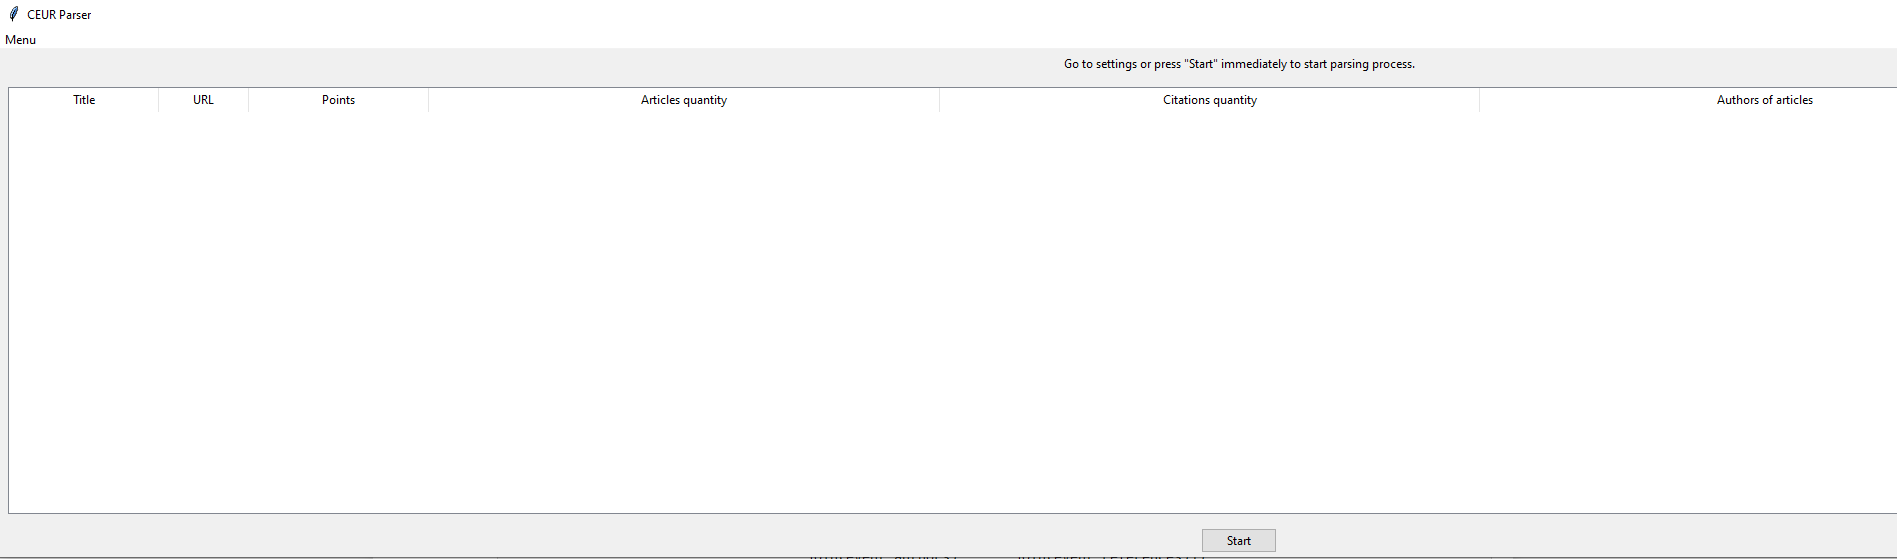
 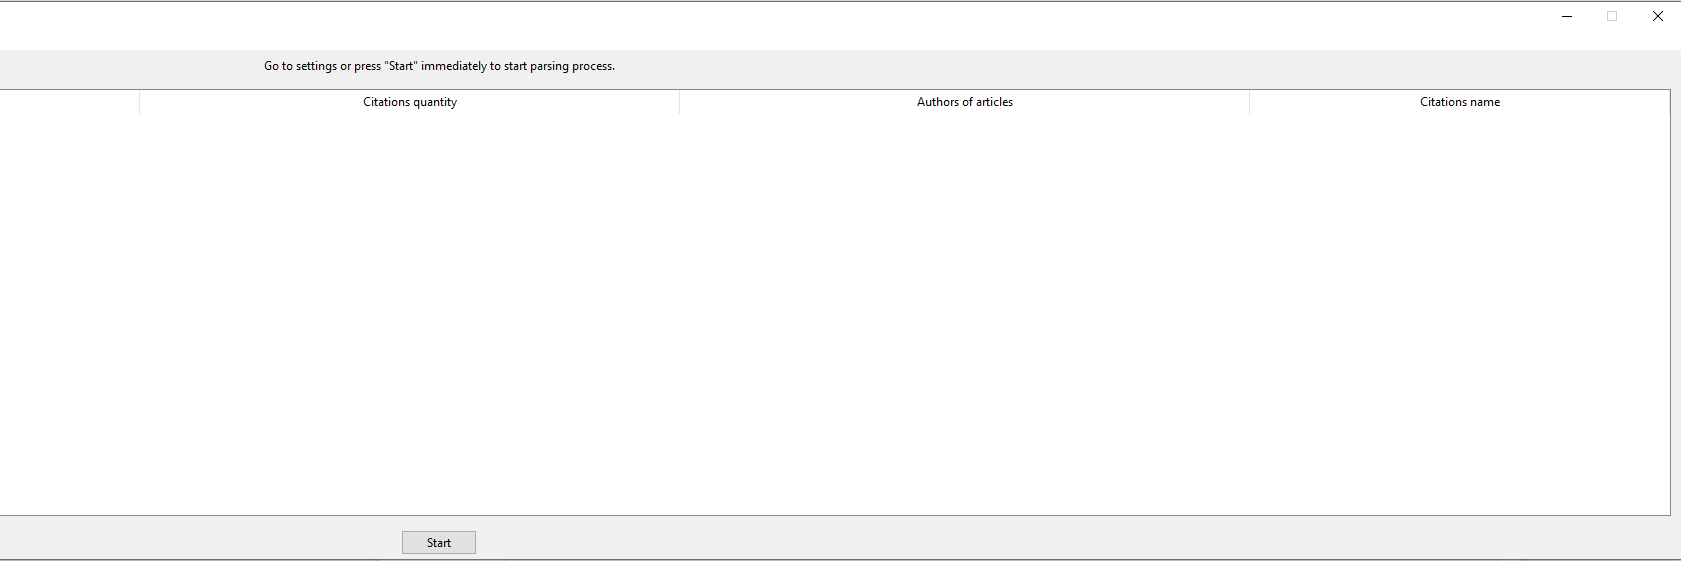
- ### _Settings window_ :
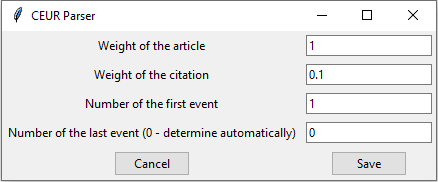
- ### _Faculty names window_ :
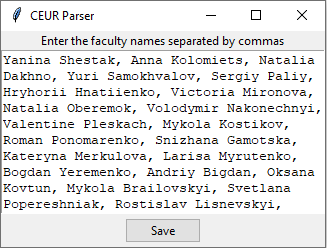
- ### _Description window_ :
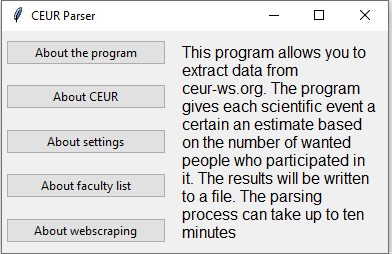
- ### _The result of parcing process_ :
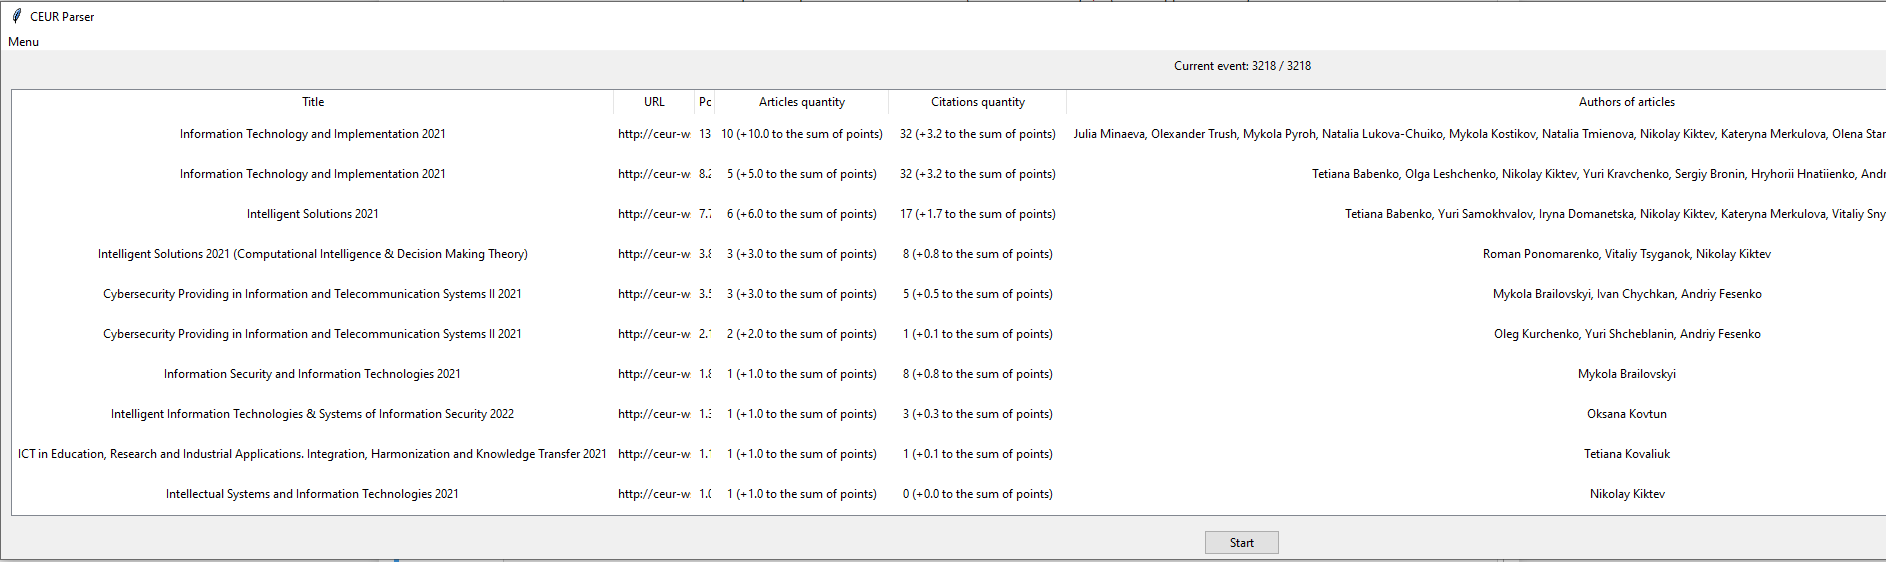
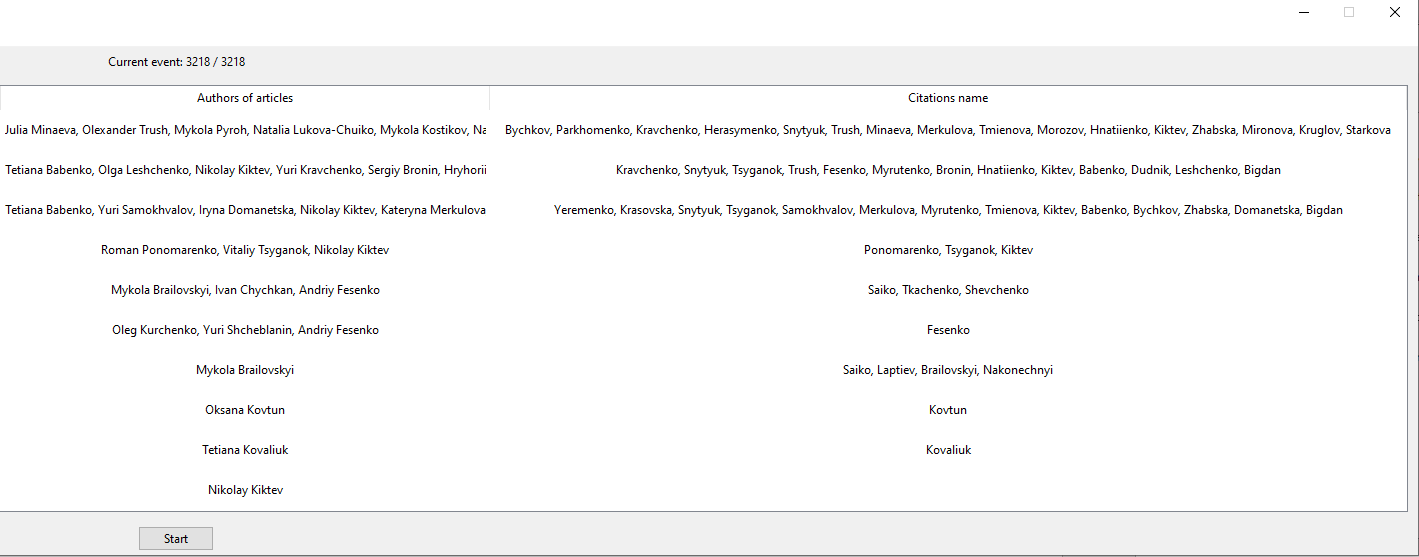